# Logistic Regression

It is a simple *classification* algorithm used when the dependent variable (target) is *categorical*. $y = \sigma(w^Tx)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import scipy.io as sio
from IPython.display import display, Markdown, Math
from pprint import pprint

%matplotlib inline

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def computeCost(X, y, theta, lamb):
    # Cost fn = -1/n ∑[y log(h(x)) + (1-y)log(1-h(x))] + λ/2n ∑[θ^2]
    y_hat = sigmoid(X * theta)
    first = np.multiply(y, np.log(y_hat))
    second = np.multiply((1 - y), np.log(1 - y_hat))
    reg = (lamb / 2 * len(X)) * np.sum(np.power(theta[1:, :], 2))
    return (-1/len(X)) * np.sum(first + second) + reg

In [4]:
def stochasticGradientDescentRidge(X, y, theta, alpha, minibatch_size, lamb=0, threshold=0.0001, iters=1000):
    """ optimizes weight vector (theta) with batch of minibatch_size in each iteration, until convergence"""

    # to store temp theta to perform simultaneous update in current iteration
    temp = np.matrix(np.zeros(theta.shape))
    parameters = theta.ravel().shape[1]
    cost = [np.inf]
    
    while True:
        # iterating over feature matrix in batches
        for b in range(math.ceil(len(X)/minibatch_size)):
            # generates random samples without replacement, all unique
            random_idx = np.random.choice(len(X), size=min(len(X), minibatch_size), replace = False)

            # Get pair of (X, y) of the current minibatch/chunk
            X_mini = X[random_idx]
            y_mini = y[random_idx]
            
            error = sigmoid(np.dot(X_mini,theta)) - y_mini
            
            # updated each parameter/weight in theta
            for j in range(parameters):
                # training element-wise multiplication of jth feature with the error
                term = np.multiply(error, X_mini[:, j])
                temp[j, 0] = theta[j, 0] - ((alpha / len(X_mini)) * (np.sum(term) + lamb * theta[j, 0]))

            theta = temp
            
        cost.append(computeCost(X, y, theta, lamb))
        
        if (cost[-2]-cost[-1]) > 0 and (cost[-2]-cost[-1]) < threshold:
            break
        
    return theta, cost

In [5]:
def plotCostperEpoch(cost):
    """ plots iteration v/s cost """
    fig, ax = plt.subplots(figsize=(14, 8))

    plt.plot(np.arange(len(cost)), cost)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title('Error vs. Training Epoch')

In [6]:
def plotLogistic(X_train, y_train, X_test, y_test, theta, title):
    """ Scatter plot to show classification using Logistic regression's hyperplane.
    
    highlights positive and negative classes in both training and test dataset.
    plots the decision boundary to classify the two classes.
    """

    # Dataframe with X and y concatenated
    test_df = pd.DataFrame(data=np.column_stack((X_test[:, 1:], y_test)), columns=['X1','X2','Y'])
    train_df = pd.DataFrame(data=np.column_stack((X_train[:, 1:], y_train)), columns=['X1','X2','Y'])

    # Segregation of Testing and Training data into + and - classes
    positive_test = test_df[test_df['Y'].isin([1])]  
    negative_test = test_df[test_df['Y'].isin([0])]

    positive_train = train_df[train_df['Y'].isin([1])]  
    negative_train = train_df[train_df['Y'].isin([0])]
    
    fig, ax = plt.subplots(figsize=(12,8))  

    w0 = theta.item(0)
    w1, w2 = theta.item(1), theta.item(2)

    x_hyperplane = np.arange(math.floor(train_df['X1'].min()), math.ceil(train_df['X1'].max()), 0.1)
    y_hyperplane = (-w0-w1*x_hyperplane)/w2

    ax.scatter(positive_train['X1'], positive_train['X2'], s=50, marker='^', label='Train Positive', c='b')  
    ax.scatter(positive_test['X1'], positive_test['X2'], s=50, marker='^', label='Test Positive', 
               facecolors='none', edgecolors='b')  
    
    ax.scatter(negative_train['X1'], negative_train['X2'], s=50, marker='o', label='Train Negative', c='r')  
    ax.scatter(negative_test['X1'], negative_test['X2'], s=50, marker='o', label='Test Negative', 
               facecolors='none', edgecolors='r')  
    
    plt.plot(x_hyperplane, y_hyperplane, 'k-', label='Decision Boundary')
    
    fig.tight_layout()
    plt.legend(bbox_to_anchor=(1, 0), loc="upper right", ncol=5,
                bbox_transform=fig.transFigure, fontsize = 'medium', columnspacing = 0.5)  
    
    ax.set_xlabel('X1')  
    ax.set_ylabel('X2') 
    plt.title(title)
    plt.show()

### Tuning the Hyperparameter for Regularization ($\lambda$):

Optimal $\lambda$: Minimum mean holdout set error

In [7]:
lambda_list = [0.01, 0.03, 0.1, 0.3, 1]

In [8]:
def regularizationParameter(X, y, kfolds, alpha, minibatch_size, threshold=0.0001,
                            lambda_list = lambda_list):
    """ finds the optimal lambda from lambda_list
    
    optimal lambda will be the one with minimum mean error on holdout set
    """
    
    theta0 = np.matrix(np.zeros((X.shape[1],1)))
    
    shuffled_idx = np.random.choice(len(X), size=len(X), replace = False)
    idx_per_fold = math.floor(len(X)/kfolds)
    if len(X) % kfolds !=0:
        kfolds+=1
        
    lambda_errorlist = defaultdict(list)
    
    for lamb in lambda_list:
        for k in range(kfolds):
            #holdout_idx = np.arange(k*idx_per_fold, (k+1)*idx_per_fold)
            holdout_idx = shuffled_idx[k*idx_per_fold : (k+1)*idx_per_fold]
            #X_holdout = X[k*idx_per_fold : (k+1)*idx_per_fold]
            #X_training = np.delete(X,holdout_idx, axis=0)
            # Holdout data - kth fold
            X_holdout = X[holdout_idx]
            y_holdout = y[holdout_idx]
            # Training data - other than kth fold
            X_training = X[~holdout_idx]
            y_training = y[~holdout_idx]
            
            thetalk, _ = stochasticGradientDescentRidge(X_training, y_training, theta0, alpha, minibatch_size, lamb, threshold)
            holdout_error_lk = computeCost(X_holdout, y_holdout, thetalk, lamb)
            
            lambda_errorlist[lamb].append(holdout_error_lk)
            #print("{0}th holdout error(λ={1}): {2}".format(k, lamb, holdout_error_lk))
            
        print("Average error on {0}-holdout sets for lamda={1} is {2:.2f}".format(kfolds, lamb, np.mean(lambda_errorlist[lamb])))
    
    # pprint(dict(lambda_errorlist))
    # find optimal lambda i.e. with mimimum mean error on k holdout sets
    lambda_optimal = min(lambda_errorlist, key= lambda l: np.mean(lambda_errorlist[l]))
    
    return lambda_optimal

In [9]:
def predict(theta, X):
    """ translates the output of the hypothesis function (h(x) = g(θ^T x)) to a class
    
    1 if g(θ^T x) >= 0.5
    0 if g(θ^T x) < 0.5"""
    
    probability = sigmoid(X * theta)
    return [1 if x >= 0.5 else 0 for x in probability]

### Dataset1

In [10]:
dataset1 = sio.loadmat('data1')

In [11]:
dataset1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_trn', 'X_tst', 'Y_trn', 'Y_tst'])

In [12]:
X1_train, y1_train = np.matrix(dataset1['X_trn']), np.matrix(dataset1['Y_trn'])
X1_test, y1_test = np.matrix(dataset1['X_tst']), np.matrix(dataset1['Y_tst'])

In [13]:
X1_train.shape, y1_train.shape

((136, 2), (136, 1))

In [14]:
X1_test.shape, y1_test.shape

((14, 2), (14, 1))

In [15]:
# Adding Intercept term (a column with all 1s) to Feature Vectors
X1_train = np.hstack((np.ones((X1_train.shape[0], 1)), X1_train))
X1_test = np.hstack((np.ones((X1_test.shape[0], 1)), X1_test))

**Mini-batch Gradient Descent**

In [16]:
alpha = 0.0001           # learning-rate
minibatch_size = 5       # batch size
kfolds_10 = 10           # 10-folds

lambda_optimal1_10k = regularizationParameter(X1_train, y1_train, kfolds_10, alpha, minibatch_size)
print("\nOptimal lambda on 1-degree polynomial data: {}".format(lambda_optimal1_10k))

Average error on 11-holdout sets for lamda=0.01 is 0.56
Average error on 11-holdout sets for lamda=0.03 is 0.58
Average error on 11-holdout sets for lamda=0.1 is 0.62
Average error on 11-holdout sets for lamda=0.3 is 0.66
Average error on 11-holdout sets for lamda=1 is 0.68

Optimal lambda on 1-degree polynomial data: 0.01


In [17]:
theta0_1 = np.matrix(np.zeros((X1_train.shape[1], 1)))
display(Markdown(r'Initial  $\theta_{ridge}$ = ') , theta0_1)

Initial  $\theta_{ridge}$ = 

matrix([[0.],
        [0.],
        [0.]])

In [18]:
theta_sg1, cost_sg1 = stochasticGradientDescentRidge(X1_train, y1_train, theta0_1, 
                                                     alpha, minibatch_size=10, lamb=lambda_optimal1_10k, 
                                                     threshold=0.0001)

display(Markdown(r'$\theta_{ridge}$' + ' for 1-degree polynomial (Stochastic Logistic Regression)'))
display(theta_sg1)

$\theta_{ridge}$ for 1-degree polynomial (Stochastic Logistic Regression)

matrix([[ 0.00695499],
        [ 0.26538926],
        [-0.19604697]])

### Classification error on training and test dataset1

In [19]:
predictions_trn = predict(theta_sg1, X1_train)  
correct = [1 if a == b[0] else 0 for (a, b) in zip(predictions_trn, y1_train.tolist())]  
accuracy = (sum(map(int, correct)) / len(correct)*100)  
print('Classification Error = {0:.2f}'.format(correct.count(0)/len(correct)))
print('No of mis-classified Training data points: {0}'.format(correct.count(0)))
print('accuracy = {0:.2f}%'.format(accuracy))

Classification Error = 0.01
No of mis-classified Training data points: 1
accuracy = 99.26%


In [20]:
predictions_tst = predict(theta_sg1, X1_test)  
correct = [1 if a == b[0] else 0 for (a, b) in zip(predictions_tst, y1_test.tolist())]  
accuracy = (sum(map(int, correct)) / len(correct)*100)  
print('Classification Error = {0:.2f}'.format(correct.count(0)/len(correct)))
print('No of mis-classified Test data points: {0}'.format(correct.count(0)))
print('accuracy = {0:.2f}%'.format(accuracy))

Classification Error = 0.00
No of mis-classified Test data points: 0
accuracy = 100.00%


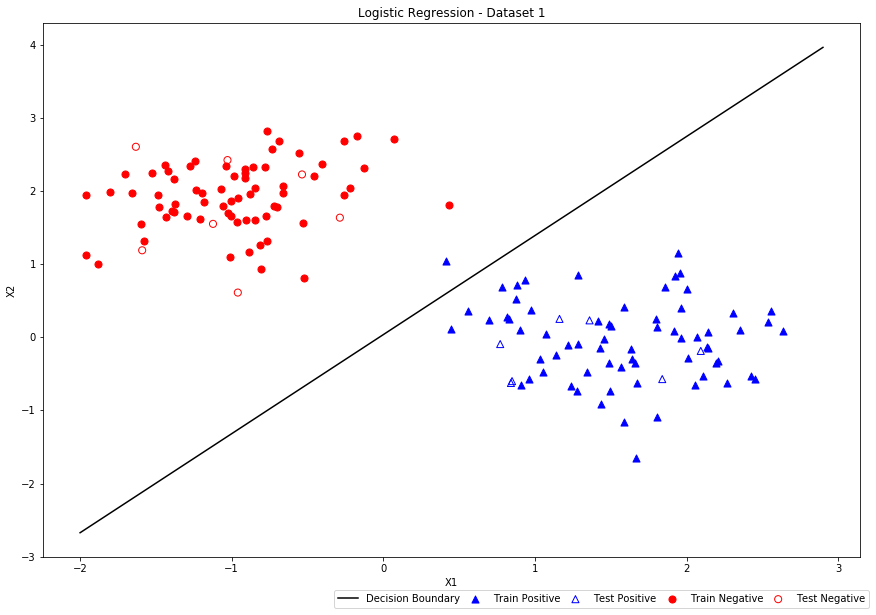

In [21]:
plotLogistic(X1_train, y1_train, X1_test, y1_test, theta_sg1, title = "Logistic Regression - Dataset 1")

### Dataset 2

In [22]:
dataset2 = sio.loadmat('data2')

In [23]:
X2_train, y2_train = np.matrix(dataset2['X_trn']), np.matrix(dataset2['Y_trn'])
X2_test, y2_test = np.matrix(dataset2['X_tst']), np.matrix(dataset2['Y_tst'])

In [24]:
X2_train = np.hstack((np.ones((X2_train.shape[0], 1)), X2_train))
X2_test = np.hstack((np.ones((X2_test.shape[0], 1)), X2_test))

**Mini-batch Gradient Descent**

In [25]:
alpha = 0.0001
minibatch_size = 5
kfolds_10 = 10

lambda_optimal2_10k = regularizationParameter(X2_train, y2_train, kfolds_10, alpha, minibatch_size)
print("\nOptimal lambda on 1-degree polynomial data: {}".format(lambda_optimal2_10k))

Average error on 11-holdout sets for lamda=0.01 is 0.69
Average error on 11-holdout sets for lamda=0.03 is 0.69
Average error on 11-holdout sets for lamda=0.1 is 0.69
Average error on 11-holdout sets for lamda=0.3 is 0.69
Average error on 11-holdout sets for lamda=1 is 0.69

Optimal lambda on 1-degree polynomial data: 0.1


In [26]:
theta0_2 = np.matrix(np.zeros((X2_train.shape[1],1)))
display(Markdown(r'Initial  $\theta_{ridge}$ = ') , theta0_2)

Initial  $\theta_{ridge}$ = 

matrix([[0.],
        [0.],
        [0.]])

In [27]:
theta_sg2, cost_sg2 = stochasticGradientDescentRidge(X2_train, y2_train, theta0_2, alpha=0.0001,
                                                     minibatch_size=10, lamb=lambda_optimal2_10k, threshold=0.0001)
display(Markdown(r'$\theta_{ridge}$' + ' for 1-degree polynomial (Stochastic Logistic Regression)'))
display(theta_sg2)

$\theta_{ridge}$ for 1-degree polynomial (Stochastic Logistic Regression)

matrix([[-0.00017902],
        [ 0.02602756],
        [-0.0131963 ]])

### Classification error on training and test dataset2

In [28]:
predictions_trn_2 = predict(theta_sg2, X2_train)  
correct = [1 if ((a == 1 and b[0] == 1) or (a == 0 and b[0] == 0)) else 0 for (a, b) in zip(predictions_trn_2, y2_train.tolist())]  
accuracy = (sum(map(int, correct)) / len(correct)*100)  
print('Classification Error = {0:.2f}'.format(correct.count(0)/len(correct)))
print('No of mis-classified Training data points: {0}'.format(correct.count(0)))
print('accuracy = {0:.2f}%'.format(accuracy))

Classification Error = 0.11
No of mis-classified Training data points: 14
accuracy = 88.89%


In [29]:
predictions_tst_2 = predict(theta_sg2, X2_test)  
correct = [1 if ((a == 1 and b[0] == 1) or (a == 0 and b[0] == 0)) else 0 for (a, b) in zip(predictions_tst_2, y2_test.tolist())]  
accuracy = (sum(map(int, correct)) / len(correct)*100)  
print('Classification Error = {0:.2f}'.format(correct.count(0)/len(correct)))
print('No of mis-classified Test data points: {0}'.format(correct.count(0)))
print('accuracy = {0:.2f}%'.format(accuracy))

Classification Error = 0.14
No of mis-classified Test data points: 2
accuracy = 85.71%


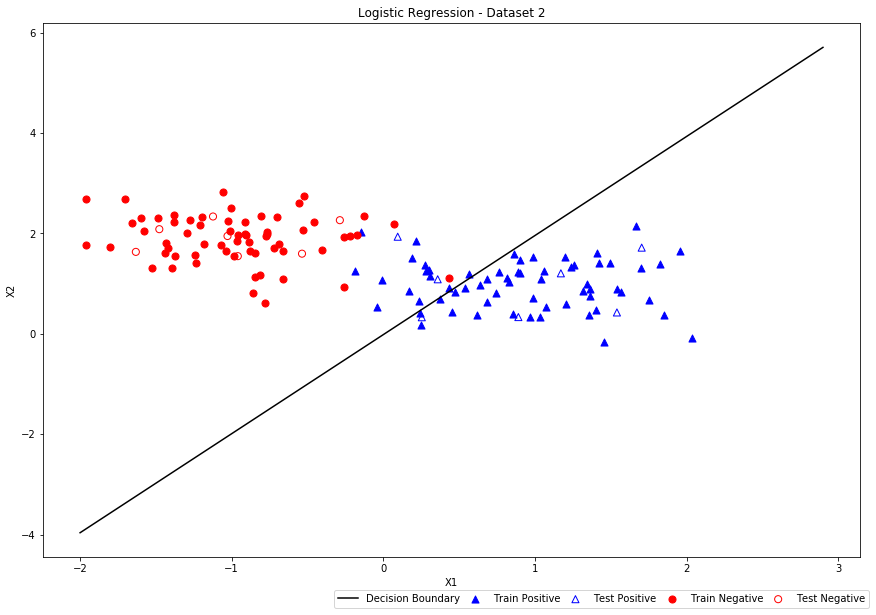

In [30]:
plotLogistic(X2_train, y2_train, X2_test, y2_test, theta_sg2, title = "Logistic Regression - Dataset 2")

Dataset 1 has very much separation in between data points of 2 classes, whereas data points from 2 classes are close enough in Dataset 2. As a result of which, the classifier has a higher error on the dataset 2 with higher no of misclassified points. 
Visually, the decision boundary works very well on dataset 1, but have a average performance on the dataset 2.